In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from pathlib import Path
import pickle

In [6]:
dataset_path = Path('../data/dataset_extracted_20200729_tma_ctrl_cc-chc_sans_normalisation.pkl')
assert dataset_path.exists()

In [ ]:
def load_data(path):
  if path.exists():
    with open(dataset_path, 'rb') as data_pkl_f:
      X_train, X_test, y_train, y_test = pickle.load(data_pkl_f)
      return X_train, X_test, y_train, y_test
  return None, None, None, None

In [ ]:
dataset = load_data(dataset_path)

In [ ]:
X_train, X_test, y_train, y_test = dataset

X_train.shape

(5349, 32320)

In [ ]:
# gestion de l'encodage des labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)

encoder.classes_, np.unique(y_test)

(array(['cc', 'chc'], dtype='<U3'), array(['cc', 'chc'], dtype='<U3'))

In [ ]:

# reshape data
input_shape = (None, X_train.shape[1], 1, 1)

X_train = X_train.reshape(((-1,) + input_shape[1:]))
X_test = X_test.reshape(((-1,) + input_shape[1:]))

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
print(y_train[:10])

[0 0 1 0 1 0 0 1 0 0]


Répartition des classe au sein du dataset (y_train)

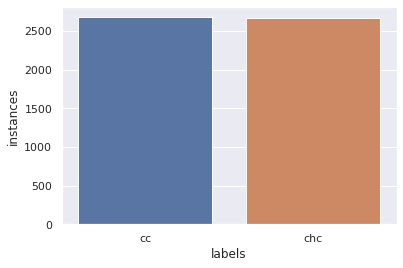

In [ ]:
df = pd.DataFrame({
    "labels": encoder.classes_,
    "instances": [ np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1) ]
})
sns.barplot(data=df, x="labels", y="instances")

Répartition des classe au sein du dataset (test)

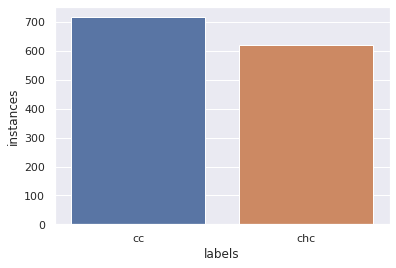

In [ ]:
df = pd.DataFrame({
    "labels": encoder.classes_,
    "instances": [ np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1) ]
})
sns.barplot(data=df, x="labels", y="instances")

---

In [2]:
from IsotopeNet import IsotopeNet

In [ ]:
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other

OPTIM = Adam(learning_rate=0.01)
LOSS = SparseCategoricalCrossentropy()

In [ ]:
isotope_model = IsotopeNet()
isotope_model.build(input_shape=input_shape)
isotope_model.summary()

isotope_model.compile(
  optimizer=OPTIM,
  loss=LOSS,
  metrics=['accuracy', 'sparse_categorical_accuracy']
)

Model: "IsotopeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual_layer (ResidualLay  multiple                 280       
 er)                                                             
                                                                 
 residual_layer_1 (ResidualL  multiple                 640       
 ayer)                                                           
                                                                 
 residual_layer_2 (ResidualL  multiple                 448       
 ayer)                                                           
                                                                 
 residual_layer_3 (ResidualL  multiple                 59        
 ayer)                                                           
                                                                 
 sequential (Sequential)     (None, 2)                 1

In [ ]:
history = isotope_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
168/168 [==============================] - 420s 2s/step - loss: 0.3466 - accuracy: 0.9033 - sparse_categorical_accuracy: 0.9033 - val_loss: 0.2493 - val_accuracy: 0.9126 - val_sparse_categorical_accuracy: 0.9126
Epoch 2/5
168/168 [==============================] - 333s 2s/step - loss: 0.1917 - accuracy: 0.9297 - sparse_categorical_accuracy: 0.9297 - val_loss: 0.2092 - val_accuracy: 0.9268 - val_sparse_categorical_accuracy: 0.9268
Epoch 3/5
168/168 [==============================] - 328s 2s/step - loss: 0.1904 - accuracy: 0.9319 - sparse_categorical_accuracy: 0.9319 - val_loss: 0.1966 - val_accuracy: 0.9238 - val_sparse_categorical_accuracy: 0.9238
Epoch 4/5
168/168 [==============================] - 326s 2s/step - loss: 0.1782 - accuracy: 0.9355 - sparse_categorical_accuracy: 0.9355 - val_loss: 0.1710 - val_accuracy: 0.9365 - val_sparse_categorical_accuracy: 0.9365
Epoch 5/5
168/168 [==============================] - 358s 2s/step - loss: 0.1586 - accuracy: 0.9424 - sparse_cat

In [ ]:
isotope_model.save('src/models/isotope_small_trained') # isotope_model.load_model(...)

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/models/isotope_small_trained/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/models/isotope_small_trained/assets


Text(0.5, 1.0, 'loss per epochs')

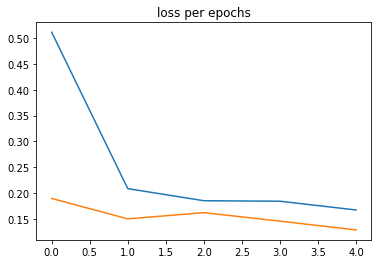

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss per epochs')

Text(0.5, 1.0, 'accuracy per epochs')

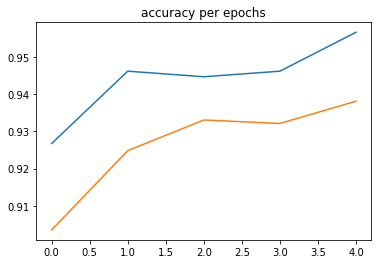

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('accuracy per epochs')

In [ ]:
eval_history = isotope_model.evaluate(X_test, y_test)
print(f'Test loss: {eval_history[0]} / Test accuracy: {eval_history[1]}')


42/42 [==============================] - 18s 428ms/step - loss: 0.1396 - accuracy: 0.9552 - sparse_categorical_accuracy: 0.9552
Test loss: 0.13963040709495544 / Test accuracy: 0.9551569223403931


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        y_true=y_test,
        y_pred=isotope_model.predict(X_test).argmax(axis=1),
        labels=encoder.transform(encoder.classes_),
        target_names=encoder.classes_))


              precision    recall  f1-score   support

          cc       0.95      0.97      0.96       717
         chc       0.96      0.94      0.95       621

    accuracy                           0.96      1338
   macro avg       0.96      0.95      0.95      1338
weighted avg       0.96      0.96      0.96      1338



Comparaison des 10 premiers résultats

In [ ]:
# np.round(isotope_model.predict(X_test[:10]), 3).argmax(axis=1)
print('y_pred')
print(isotope_model.predict(X_test[:10]).argmax(axis=1))
print('\ny_true')
print(y_test[:10])


y_pred
[0 0 0 0 1 1 1 1 1 1]

y_true
[0 0 0 0 1 1 1 1 1 1]


# Entraînement du model ResNet à ~ 2.9M de paramètres


In [3]:
from ResidualNet import ResidualNet

In [ ]:
resnet_model = ResidualNet()
resnet_model.build(input_shape=input_shape)
resnet_model.summary()

resnet_model.compile(
  optimizer=OPTIM,
  loss=LOSS,
  metrics=['accuracy', 'sparse_categorical_accuracy']
)

Model: "ResidualNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2, 1, 256)         2985936   
                                                                 
 sequential_2 (Sequential)   (None, 2)                 514       
                                                                 
Total params: 2,986,450
Trainable params: 2,978,962
Non-trainable params: 7,488
_________________________________________________________________


In [ ]:
resnet_history = resnet_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=5,
    validation_data=(X_test, y_test),
)

Epoch 1/5
168/168 [==============================] - 2030s 12s/step - loss: 1153751187456.0000 - accuracy: 0.7014 - sparse_categorical_accuracy: 0.7014 - val_loss: 3991896320.0000 - val_accuracy: 0.6824 - val_sparse_categorical_accuracy: 0.6824
Epoch 2/5
168/168 [==============================] - 2015s 12s/step - loss: 642727936.0000 - accuracy: 0.8024 - sparse_categorical_accuracy: 0.8024 - val_loss: 331508384.0000 - val_accuracy: 0.7422 - val_sparse_categorical_accuracy: 0.7422
Epoch 3/5
168/168 [==============================] - 2057s 12s/step - loss: 250250944.0000 - accuracy: 0.8381 - sparse_categorical_accuracy: 0.8381 - val_loss: 163923776.0000 - val_accuracy: 0.7825 - val_sparse_categorical_accuracy: 0.7825
Epoch 4/5
168/168 [==============================] - 2056s 12s/step - loss: 231135200.0000 - accuracy: 0.8332 - sparse_categorical_accuracy: 0.8332 - val_loss: 166430592.0000 - val_accuracy: 0.8909 - val_sparse_categorical_accuracy: 0.8909
Epoch 5/5
168/168 [================

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


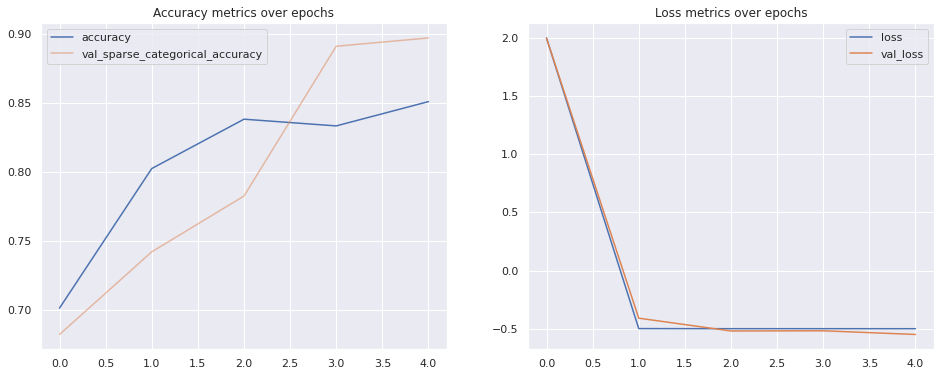

In [ ]:
from sklearn.preprocessing import scale

# Note: sparse_categorical_accuracy and accuracy are the same

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(resnet_history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy', alpha=0.5)
plt.title('Accuracy metrics over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(scale(resnet_history.history['loss']), label='loss')
plt.plot(scale(resnet_history.history['val_loss']), label='val_loss')
plt.title('Loss metrics over epochs')
plt.legend()


---
# Utilisation du dataset complet

In [7]:
large_dataset_path = Path('../data/large_dataset_extracted_20200729_tma_ctrl_cc-chc_sans_normalisation.pkl')
assert large_dataset_path.exists()

In [ ]:
# X_train, X_test, y_train, y_test = None, None, None, None
del X_train
del X_test
del y_train
del y_test

# large_dataset = load_data(large_dataset_path)

In [ ]:
with open(large_dataset_path, 'rb') as f:
  X_tr, X_te, y_tr, y_te = pickle.load(f)

X_train = X_tr
X_test = X_te
y_train = y_tr
y_test = y_te

print(X_train.shape)
assert X_train.shape[0] > 5349

(19222, 32320)


In [ ]:
X_train = X_train.reshape((-1, X_train.shape[1], 1, 1))
X_test = X_test.reshape((-1, X_train.shape[1], 1, 1))

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

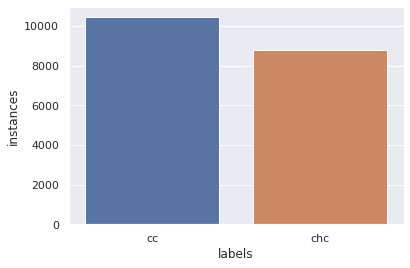

In [ ]:
df = pd.DataFrame({
    "labels": encoder.classes_,
    "instances": [ np.count_nonzero(y_train == 0), np.count_nonzero(y_train == 1) ]
})
sns.barplot(data=df, x="labels", y="instances")

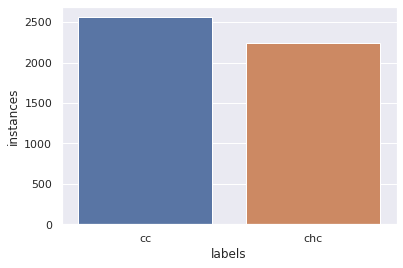

In [ ]:
df = pd.DataFrame({
    "labels": encoder.classes_,
    "instances": [ np.count_nonzero(y_test == 0), np.count_nonzero(y_test == 1) ]
})
sns.barplot(data=df, x="labels", y="instances")

In [ ]:
isotope_model_large_data = IsotopeNet()
isotope_model_large_data.build(input_shape=(None, X_train.shape[1], 1, 1))
isotope_model_large_data.summary()

isotope_model_large_data.compile(
  optimizer=OPTIM,
  loss=LOSS,
  metrics=['accuracy', 'sparse_categorical_accuracy']
)

Model: "IsotopeNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual_layer (ResidualLay  multiple                 280       
 er)                                                             
                                                                 
 residual_layer_1 (ResidualL  multiple                 640       
 ayer)                                                           
                                                                 
 residual_layer_2 (ResidualL  multiple                 448       
 ayer)                                                           
                                                                 
 residual_layer_3 (ResidualL  multiple                 59        
 ayer)                                                           
                                                                 
 sequential (Sequential)     (None, 2)                 1

In [ ]:
history = isotope_model_large_data.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    validation_data=(X_test, y_test)
)

Epoch 1/5
301/301 [==============================] - 1303s 4s/step - loss: 0.3485 - accuracy: 0.8979 - sparse_categorical_accuracy: 0.8979 - val_loss: 0.2010 - val_accuracy: 0.9272 - val_sparse_categorical_accuracy: 0.9272
Epoch 2/5
301/301 [==============================] - 1178s 4s/step - loss: 0.2038 - accuracy: 0.9307 - sparse_categorical_accuracy: 0.9307 - val_loss: 0.2011 - val_accuracy: 0.9251 - val_sparse_categorical_accuracy: 0.9251
Epoch 3/5
301/301 [==============================] - 1165s 4s/step - loss: 0.1848 - accuracy: 0.9351 - sparse_categorical_accuracy: 0.9351 - val_loss: 0.1438 - val_accuracy: 0.9469 - val_sparse_categorical_accuracy: 0.9469
Epoch 4/5
301/301 [==============================] - 1166s 4s/step - loss: 0.1658 - accuracy: 0.9393 - sparse_categorical_accuracy: 0.9393 - val_loss: 0.1453 - val_accuracy: 0.9465 - val_sparse_categorical_accuracy: 0.9465
Epoch 5/5
301/301 [==============================] - 1168s 4s/step - loss: 0.1588 - accuracy: 0.9420 - spars

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
        y_true=y_test,
        y_pred=isotope_model_large_data.predict(X_test).argmax(axis=1),
        labels=encoder.transform(encoder.classes_),
        target_names=encoder.classes_))